# Who is in the news?

First we must install a couple of dependencies, import them, and enable inline plotting.

In [1]:
%%capture
# ^ hiding large cell output. disable for logs.
!pip3 install spacy==2.3.4 pandas==1.1.4 numpy==1.19.4 matplotlib==3.3.3
!python3 -m spacy download en_core_web_sm

In [2]:
import spacy
import pandas as pd

In [3]:
%matplotlib inline


Bad key backend.qt4 in file /etc/matplotlib/matplotlibrc, line 43 ('backend.qt4 : PyQt4        # PyQt4 | PySide')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution


## Load data

Data sourced from [Kaggle](https://www.kaggle.com/notlucasp/financial-news-headlines) and licensed as public domain.

In [4]:
reuters_headline_df = pd.read_csv('reuters_headlines.csv', parse_dates=[1])

## Extract entities with spaCy

To detect entities in text, we must use a statistical model. Here, we use spaCy's "en_core_web_sm" model. This is an English language model trained on web data, and is lightweight at 11MB. Larger versions of this model, and their performance characteristics, can be found in the [spaCy docs](https://spacy.io/models/en). spaCy also provides support for [non-English languages](https://spacy.io/usage/models#languages).

In [5]:
nlp = spacy.load('en_core_web_sm')

To extract entities from many headlines, it is considerably more performant to use spaCy's built in pipeline abstraction than to `apply` the operation with pandas. Since we care only about named entity extraction, we disable the tagger and parser to avoid unnecessary work, improving speed.

In [6]:
entity_pipe = nlp.pipe(reuters_headline_df.Headlines, disable=['tagger', 'parser'])

In [7]:
# even with above performance considerations, this cell takes a minute
reuters_headline_df['Entities'] = [x.ents for x in entity_pipe]

Construct a new DataFrame with only the columns we care about.

In [8]:
entity_df = (
    reuters_headline_df
    .explode('Entities')
    [['Time', 'Headlines', 'Entities']]
    .rename(columns={'Entities': 'Entity', 'Headlines': 'Headline', 'Time': 'Date'})
    .dropna()
    .assign(
        Label = lambda df: df.Entity.apply(lambda x: x.label_),
        Entity = lambda df: df.Entity.apply(lambda x: x.text)
    )
    .reset_index(drop=True)
)

In [9]:
entity_df.head()

,Date,Headline,Entity,Label
0,2020-07-18,TikTok considers London and other locations fo...,London,GPE
1,2020-07-18,Disney cuts ad spending on Facebook amid growi...,Facebook,ORG
2,2020-07-18,Trail of missing Wirecard executive leads to B...,Wirecard,ORG
3,2020-07-18,Trail of missing Wirecard executive leads to B...,Belarus,GPE
4,2020-07-18,Trail of missing Wirecard executive leads to B...,Der Spiegel,PERSON


Clearly, this is not perfect. Der Spiegel is not a person. Without a labeled test set, we cannot verify the robustness of the entity extraction on our particular data set. Metrics for the spaCy models are reported on the corresponding model page. It is an unavoidable reality of statistical models of text that they are imperfect.

## Most mentioned organisations

We can now query. For instance, we could ask which organisations have been reported about most (by Reuters) in 2020:

In [10]:
(
    entity_df
    [(entity_df.Label == "ORG") & (entity_df.Date.dt.year == 2020)]
    .groupby('Entity')
    .agg({'Headline': len})
    .sort_values(by='Headline', ascending=False)
    .reset_index()
    .rename(columns={'Headline': '2020 Count'})
    .head(10)
)

,Entity,2020 Count
0,Fed,256
1,Boeing,211
2,EU,194
3,Amazon,145
4,Huawei,126
5,Apple,113
6,Airbus,109
7,Facebook,94
8,MAX,93
9,Lufthansa,93


So the organisation with the most headlines in 2020 is the "Fed"&mdash;the U.S. Federal Reserve Board. This is believable. Let's see some of those headlines:

In [11]:
entity_df[(entity_df.Date.dt.year == 2020) & (entity_df.Entity == "MAX")].sample(10).Headline.values

array(['Airlines scour the world for scarce 737 MAX simulators',
       'Boeing scours idle 737 MAX plant for industrial snags',
       'U.S. regulator: Airlines should complete inspections on 737 MAX panels before flying',
       'Major 737 MAX buyer Air Lease remains confident in demand for jet',
       'Latest 737 MAX delay prompts big buyer flydubai to consider leasing options',
       'Boeing finds debris in fuel tanks of many undelivered 737 MAX jets',
       'Trump urges Boeing to move fast on resolving 737 MAX issues',
       'Exclusive: Boeing plans 737 MAX production restart by May - sources',
       "China's CDB Financial scraps purchase of 29 Boeing 737 MAX jets",
       'Boeing supplier Spirit announces layoffs due to virus, 737 MAX impacts'],
      dtype=object)

## Timeline of mentions for a named entity

We can also look at the occurrence of an organisation in the news over time.

In [12]:
def occurence_plot(entity_name):
    ax = (
        entity_df
        [entity_df.Entity == entity_name]
        .groupby('Date')
        .agg(len)
        .plot(
            y='Entity',
            drawstyle='steps',
            legend=False,
            figsize=(8,2)
        )
    )
    ax.set_ylabel('Daily count')

For instance, Boeing:

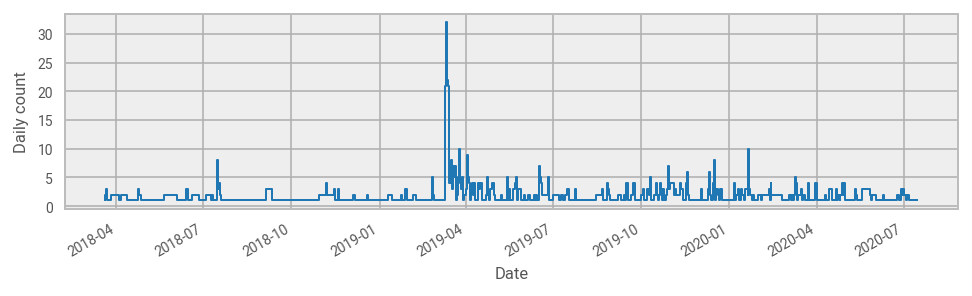

In [13]:
occurence_plot('Boeing')

There's a prominent spike in articles around March-April 2019. This corresponds to the [Boeing 737 MAX groundings](https://en.wikipedia.org/wiki/Boeing_737_MAX_groundings) following two unfortunate crashes. This also explains the presence of the "MAX" entity (misidentified as an organisation) in the top 10 mentioned organisations in 2020 (as testing continues).